# $$\text{Project 2}$$

$$\text{Group 34:}$$
$$Rohitashwa \text{ } Chakraborty, \text{ } Jaquelin \text{ } Solis, \text{ } Lorraine \text{ } Zhou \text{ } $$


In [22]:
import pandas as pd
import numpy as np
import gurobi as gb
import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

GUROBI_TIMER = 3600

# Gurobi Helper Function

In [23]:
def print_equations(obj, constraint, sense, b, variable = [" " for i in range(100)]):
    '''
        Helper Function to help me visualize the Constraints equations
    '''
    print("Optimise System of equations:")
    for i in range(constraint.shape[0]):
        print("\t"+str(i+1)+")",end=" ")
        for j in range(constraint.shape[1]):
            char = variable[j]
            print(str(round(constraint[i,j],5))+"."+char,end=" + ")
        print("\b\b "+sense[i]+"= "+str(b[i]))
    print("\nSubject to:", end=" ")

    i = 0
    for item in obj:
        char = variable[i]
        print(str(round(item,3))+char,end=" + ")
        i +=1

    print("\b\b")
    return

# Initialise 2019 Data

In [24]:
stock_2019 = pd.read_csv("stocks2019.csv", converters= {"X": pd.to_datetime}).set_index("X").astype("float")
stock_2019.head()

,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,182.458298,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,179.681961,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,185.824142,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715
2019-01-07,6488.250000,47.799141,229.259995,20.570000,107.940002,189.919998,1075.920044,1068.390015,1629.510010,188.324738,...,29.180000,271.000000,151.399994,108.787117,175.850006,65.733910,163.500000,36.521275,46.108707,87.434891
2019-01-08,6551.850098,49.247898,232.679993,20.750000,108.610001,192.949997,1085.369995,1076.280029,1656.579956,190.739777,...,29.480000,276.000000,156.919998,109.755516,178.190002,67.049149,166.949997,36.170105,46.643410,85.769180


In [25]:
(stock_2019.columns =="BKNG").any()

True

In [26]:
index_ret = stock_2019["NDX"].pct_change()[1:]

ret_2019 = stock_2019.drop("NDX", axis = 1).pct_change()[1:]

tic_2019 = ret_2019.columns
N = len(tic_2019)

print(ret_2019.shape)
ret_2019.head()

(250, 100)


,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
X,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.035509,-0.039498,-0.094530,0.022030,-0.085791,-0.027696,-0.028484,-0.025242,-0.015216,-0.060405,...,-0.022834,-0.018591,-0.034989,-0.030557,-0.002133,-0.010435,-0.035808,-0.068217,-0.003940,-0.037651
2019-01-04,0.039903,0.048632,0.114370,0.057779,0.010445,0.051294,0.053786,0.050064,0.034184,0.024278,...,0.058976,0.047954,0.044744,0.044147,0.054785,0.033269,0.060577,0.042356,0.009786,0.046303
2019-01-07,0.028196,0.013573,0.082632,0.018302,0.017192,-0.001994,-0.002167,0.034353,0.013457,0.006288,...,0.022067,0.062620,0.016312,0.001000,0.018240,0.005749,0.000918,0.035522,-0.004330,0.026415
2019-01-08,0.030309,0.014918,0.008751,0.006207,0.015954,0.008783,0.007385,0.016612,0.012824,0.024396,...,0.010281,0.018450,0.036460,0.008902,0.013307,0.020009,0.021101,-0.009615,0.011597,-0.019051
2019-01-09,0.017210,0.011819,-0.026988,0.012430,0.038196,-0.003427,-0.001505,0.001714,-0.001196,0.025340,...,0.023745,0.018804,-0.008157,0.003781,0.023065,0.012050,-0.004612,0.044083,-0.007984,0.008972


## Correlation Matrix

In [27]:
corr_2019 = np.round(np.corrcoef(ret_2019.T), 5)

pd.DataFrame(corr_2019, index= pd.Series(tic_2019, name = "index"), columns= pd.Series(tic_2019, name = "fund"))

fund,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
index,,,,,,,,,,,,,,,,,,,,,
ATVI,1.00000,0.39994,0.36538,0.22316,0.21628,0.43310,0.42678,0.46708,0.20396,0.32935,...,0.32291,0.12824,0.46485,0.31655,0.25968,0.21815,0.31166,0.30308,0.04339,0.24967
ADBE,0.39994,1.00000,0.45285,0.36893,0.36337,0.55212,0.54040,0.59824,0.29198,0.47382,...,0.36039,0.20115,0.71134,0.54124,0.40217,0.22811,0.65043,0.36152,0.20740,0.28950
AMD,0.36538,0.45285,1.00000,0.30183,0.34425,0.41886,0.41725,0.54930,0.15145,0.50373,...,0.33278,0.21062,0.49834,0.33090,0.27298,0.28195,0.40763,0.43889,0.01728,0.47801
ALXN,0.22316,0.36893,0.30183,1.00000,0.33243,0.31599,0.30770,0.36317,0.34202,0.31704,...,0.25714,0.40894,0.35058,0.19149,0.52242,0.19272,0.41640,0.28991,0.04795,0.20036
ALGN,0.21628,0.36337,0.34425,0.33243,1.00000,0.24875,0.25032,0.39928,0.26460,0.32828,...,0.17596,0.12856,0.36089,0.25185,0.33498,0.21959,0.30897,0.28441,0.08806,0.25393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBA,0.21815,0.22811,0.28195,0.19272,0.21959,0.23290,0.23060,0.28817,0.19449,0.34786,...,0.25705,0.14533,0.19547,0.12612,0.21458,1.00000,0.21164,0.29631,-0.13080,0.27664
WDAY,0.31166,0.65043,0.40763,0.41640,0.30897,0.37949,0.37183,0.42475,0.21171,0.35173,...,0.23504,0.26955,0.56967,0.40148,0.37605,0.21164,1.00000,0.31570,0.20924,0.25412
WDC,0.30308,0.36152,0.43889,0.28991,0.28441,0.32862,0.32211,0.41962,0.17262,0.60293,...,0.37721,0.12646,0.33192,0.30856,0.31477,0.29631,0.31570,1.00000,-0.07612,0.51696


# $\text{LP }1:$ Stock Selection

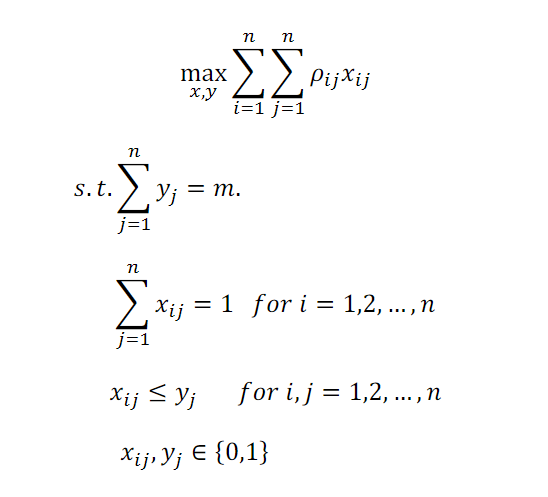

## Optimisation Model (Version 1):
$N^2 + N$ terms

In [28]:
def stock_selector(M: int = 5, verbose: str = False):
    ## Objective Function Vector
    obj = np.hstack(
            (corr_2019,
            np.array([[0]]*N))
        ).flatten()

    constraints = 1 + N + N**2
    variables = obj.shape[0]
    vars = [" x"+str(i+1) for i in range(variables)]

    # ## Constraint Matrix
    A = np.zeros((constraints, variables))

    for i in range(N):
        A[0,((N+1)*(i+1))-1] = 1                              # Select M stocks
        A[1+i, (N+1)*(i): (N+1)*(i+1)-1] = 1                    # Sum( Xij) = 1
        for j in range(N):
            A[N+1+(N*i)+j, (j*(N+1))+i] = 1                             # Stock i is selectable only if I is in J
            A[N+1+(N*i)+j,((N+1)*(i+1))-1] = -1                             # Stock i is selectable only if I is in J

    A = A.astype('int')

    ## b Vector
    b = np.array([M]+ [1]*N + [0]*(N**2))

    ## Equality / Sense Vector
    sense = np.array(["="]*(1 + N) + ["<"]*(N**2))

    ## Optimisation Model at work (Maximise)
    model = gb.Model()
    model_X = model.addMVar(variables, vtype="B")
    model_constraints = model.addMConstrs(A, model_X, sense, b)
    model.setMObjective(None, obj, 0, sense=gb.GRB.MAXIMIZE)
    model.Params.OutputFlag = 0

    model.optimize()
    optimal_obj = model.objVal
    optimal_values = model_X.x.reshape(N, N+1)[:,-1].astype('int')

    # Output
    if verbose:
        if N <= 5:
            print_equations(obj, A, sense, b)
        print("Number of Variables:",obj.shape)
        print("Optimal Stocks to select:",", ".join(tic_2019[optimal_values == 1].tolist()))
    return tic_2019[optimal_values!= 0]

## Run

In [29]:
M = 5
# M = int(input("Enter Number of Stocks to select:"))
# print("Number of Stocks to select: ",M)

fund = stock_selector(M, verbose = True)
print("Number of stocks Selected: ", len(fund))

Number of Variables: (10100,)
Optimal Stocks to select: LBTYK, MXIM, MSFT, VRTX, XEL
Number of stocks Selected:  5


### Time per run

In [30]:
# %timeit stock_selector(M)

# $\text{LP }2:$ Portfolio weights

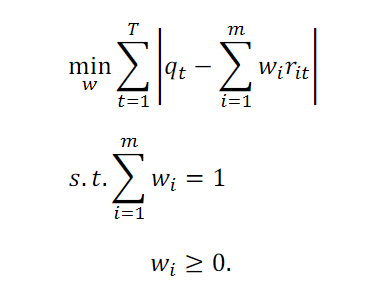

## Optimizer Function

In [31]:
def weight_optimizer(index_returns: pd.Series, returns_data:pd.Series, tickers: list, verbose: bool = False)-> pd.Series:
    M = len(tickers)
    days = returns_data.shape[0]
    ## Objective Function Vector
    obj  = np.array([1]*days +[0]*( len(tickers)))
    variables = obj.shape[0]
    constraints = 2*days + 1

    vars = [" x"+str(i+1) for i in range(variables)]

    # ## Constraint Matrix
    A = np.zeros((constraints,variables))
    b= [1]
    sense = ["="]
    # A[0,0] = 1
    A[0,-M:] = 1
    i = 1
    for date, row  in returns_data.iterrows():
        A[(2*i) -1 ,   i-1 ] = 1
        A[(2*i) -1 ,   -M: ] = row.tolist()
        
        A[(2*i) ,   i-1 ] = 1
        A[(2*i) ,   -M: ] = (-row).tolist()

        b.extend([index_returns[date], -index_returns[date]])

        sense.extend([">"]*2)
        i += 1
        
    # print(A)
    ## Optimisation Model at work (Maximise)
    model = gb.Model()
    model_X = model.addMVar(variables, vtype= gb.GRB.CONTINUOUS)
    model_constraints = model.addMConstrs(A, model_X, sense, b)
    model.setMObjective(None, obj, 0, sense=gb.GRB.MINIMIZE)
    model.Params.OutputFlag = 0

    model.optimize()
    optimal_obj = model.objVal
    optimal_values = model_X.x[-M:]#.reshape((2,N))
    
    # Output 
    if verbose:
        if days <= 7:
            print_equations(obj, A, sense, b)
        print("Optimal Cost to the nearest dollar:", round(optimal_obj,5))
        print("Optimal Weights to select:", optimal_values)
    return pd.Series(optimal_values, index = tickers), optimal_obj

## Run

In [32]:
days = 3
wt, optimal_error = weight_optimizer(index_returns= index_ret,#.iloc[:days], 
                returns_data= ret_2019[fund],#.iloc[:days],
                tickers= fund,
                verbose= True)

print("Error: ", (abs(index_ret - wt @ ret_2019[fund].T)).sum())
print(optimal_error)

Optimal Cost to the nearest dollar: 0.78918
Optimal Weights to select: [0.04886175 0.21038806 0.58035198 0.07119022 0.089208  ]
Error:  0.7891782824631475
0.7891782824631473


In [33]:
# %timeit weight_optimizer(index_returns= index_ret, returns_data= ret_2019[fund], tickers= fund)
wt

LBTYK    0.048862
MXIM     0.210388
MSFT     0.580352
VRTX     0.071190
XEL      0.089208
dtype: float64

## Calculate Returns

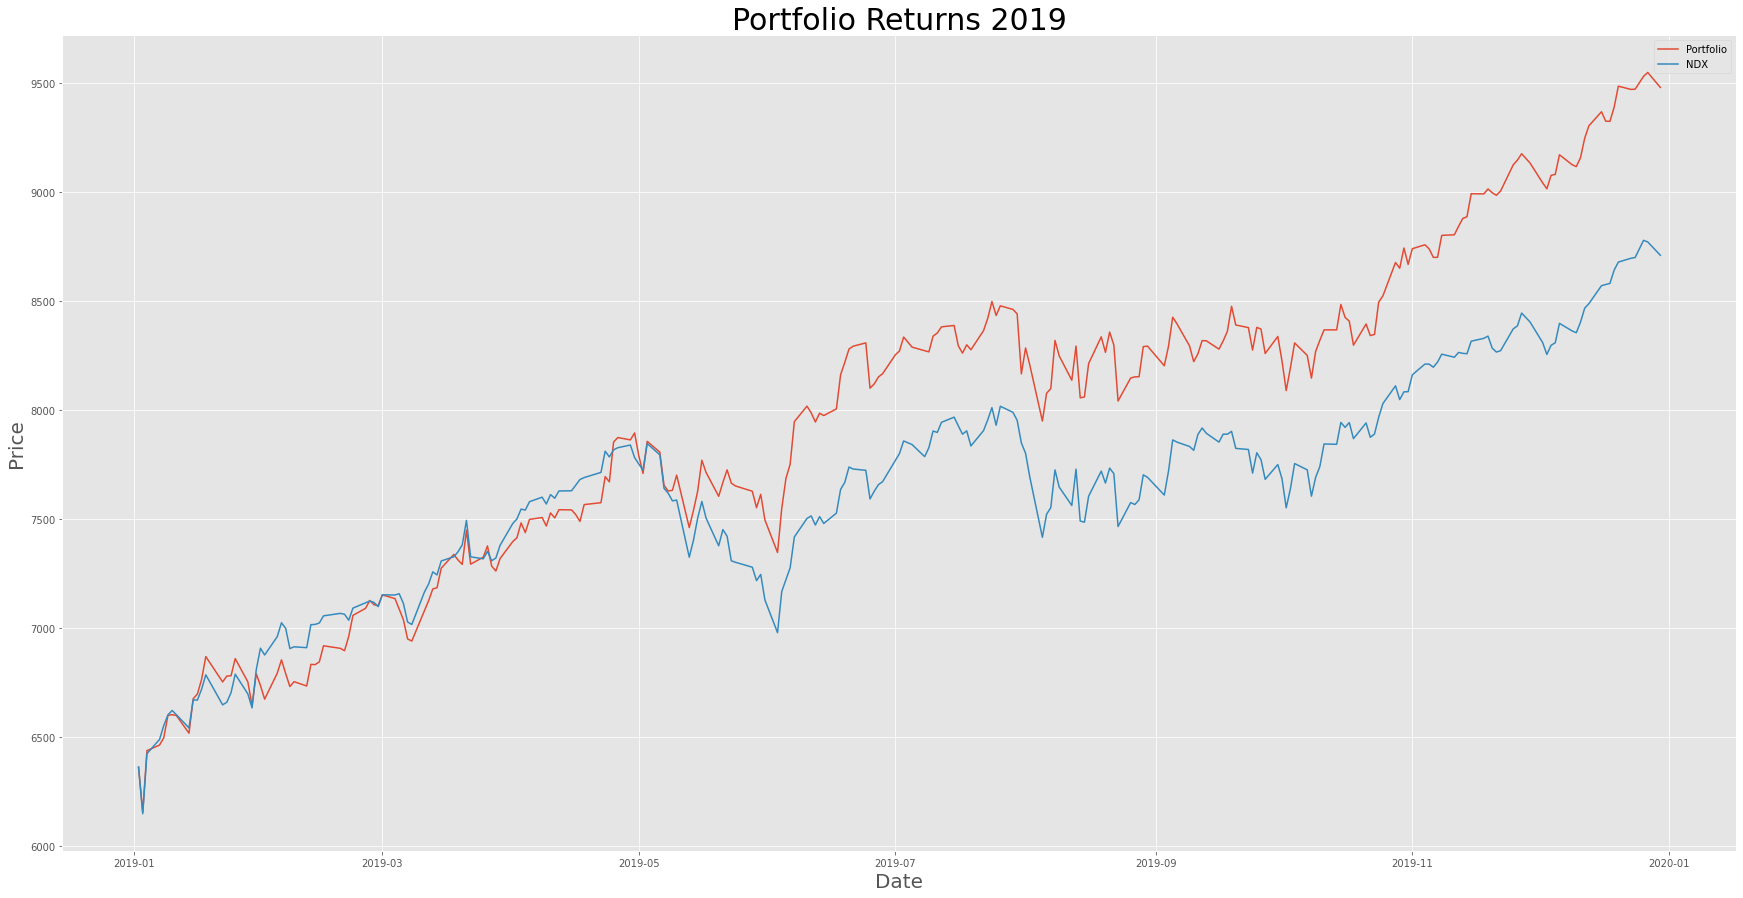

In [34]:
def plot_returns(benchmark: str, portfolio: list, data: pd.DataFrame, year: int)-> None:
    ticker = portfolio.index.tolist()

    portfolio_returns = wt @ data[ticker].T
    portfolio_returns *= data[benchmark][0]/portfolio_returns[0]

    plt.figure(figsize=(30,15))
    plt.xlabel("Date", fontsize = 20)
    plt.ylabel("Price", fontsize = 20)
    plt.title("Portfolio Returns {yr}".format(yr= year), fontsize = 30)
    plt.plot(portfolio_returns, label = "Portfolio")
    plt.plot(data[benchmark], label = benchmark)
    plt.legend()
    return

plot_returns(benchmark= "NDX", portfolio = wt, data = stock_2019, year= 2019)

# Initialise 2020 Data

In [35]:
stock_2020 = pd.read_csv("stocks2020.csv", converters= {"Unnamed: 0": pd.to_datetime}).set_index("Unnamed: 0").astype("float")
index_ret_20 = stock_2020["NDX"].pct_change()[1:]
ret_2020 = stock_2020.drop("NDX", axis = 1).pct_change()[1:]#.iloc[:,:3]

print(ret_2020.shape)
ret_2020.head()

(251, 100)


,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.000341,-0.007834,-0.010183,-0.013260,-0.011421,-0.005231,-0.004907,-0.012139,-0.006789,-0.017604,...,-0.021369,-0.017207,0.021095,0.009728,-0.006699,0.000000,0.005852,-0.015392,0.004809,-0.023020
2020-01-06,0.018238,0.005726,-0.004321,0.001598,0.019398,0.026654,0.024657,0.014886,0.007674,-0.011749,...,-0.013543,0.003118,0.009259,0.002294,0.027755,0.008632,0.006234,-0.019192,-0.001436,-0.020844
2020-01-07,0.010043,-0.000959,-0.002893,0.002533,-0.009864,-0.001932,-0.000624,0.002092,-0.009405,0.022751,...,0.045951,0.008528,0.002318,0.008369,-0.001071,-0.005035,0.020414,0.067698,-0.002077,0.022830
2020-01-08,-0.007623,0.013438,-0.008705,0.016191,0.010386,0.007118,0.007880,-0.007809,0.000756,0.009032,...,-0.012323,0.019400,0.004626,0.009208,0.032620,-0.058357,0.033304,0.014484,-0.000961,-0.002815
2020-01-09,-0.009018,0.007636,0.023834,0.019893,0.036853,0.010498,0.011044,0.004799,0.002980,0.000000,...,0.006781,0.021318,0.023169,0.009638,-0.003592,-0.020598,0.004309,-0.000291,0.002244,0.023493


# $\text{Question }2:$

Absolute Index Mimicking Error in 2020: 1.1124373455076464


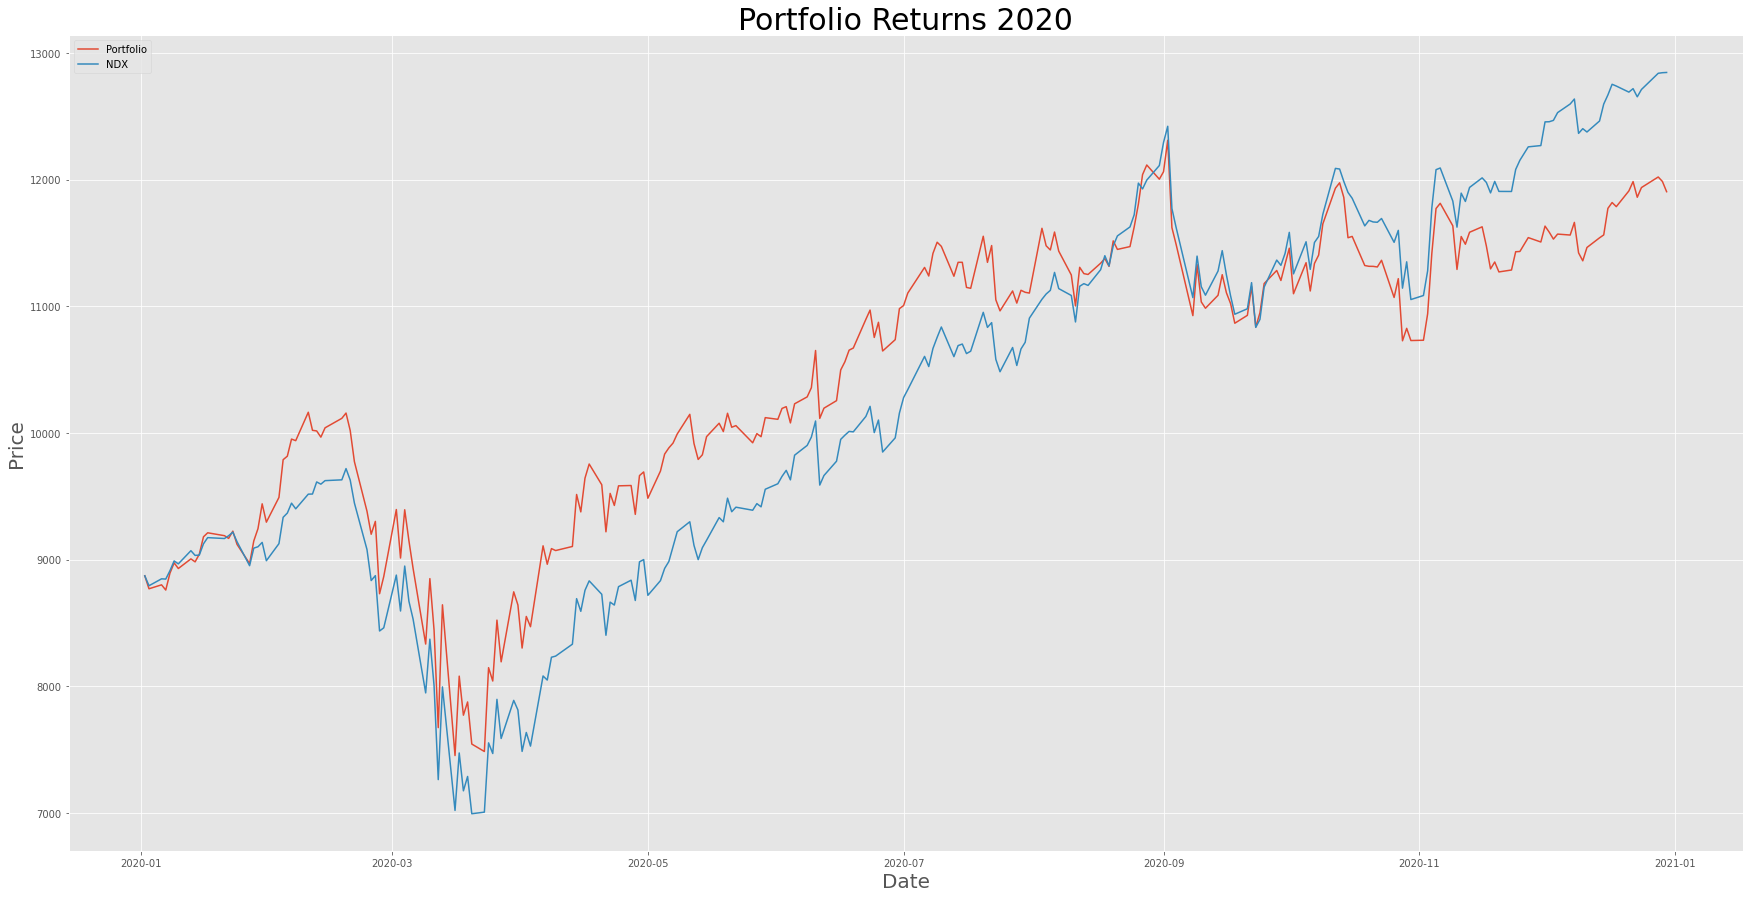

In [36]:
print("Absolute Index Mimicking Error in 2020:", (abs(index_ret_20 - wt @ ret_2020[fund].T)).sum())
plot_returns(benchmark= "NDX", portfolio = wt, data = stock_2020, year= 2020)

# $\text{Question }3:$ 

100%|██████████| 20/20 [00:28<00:00,  1.45s/it]


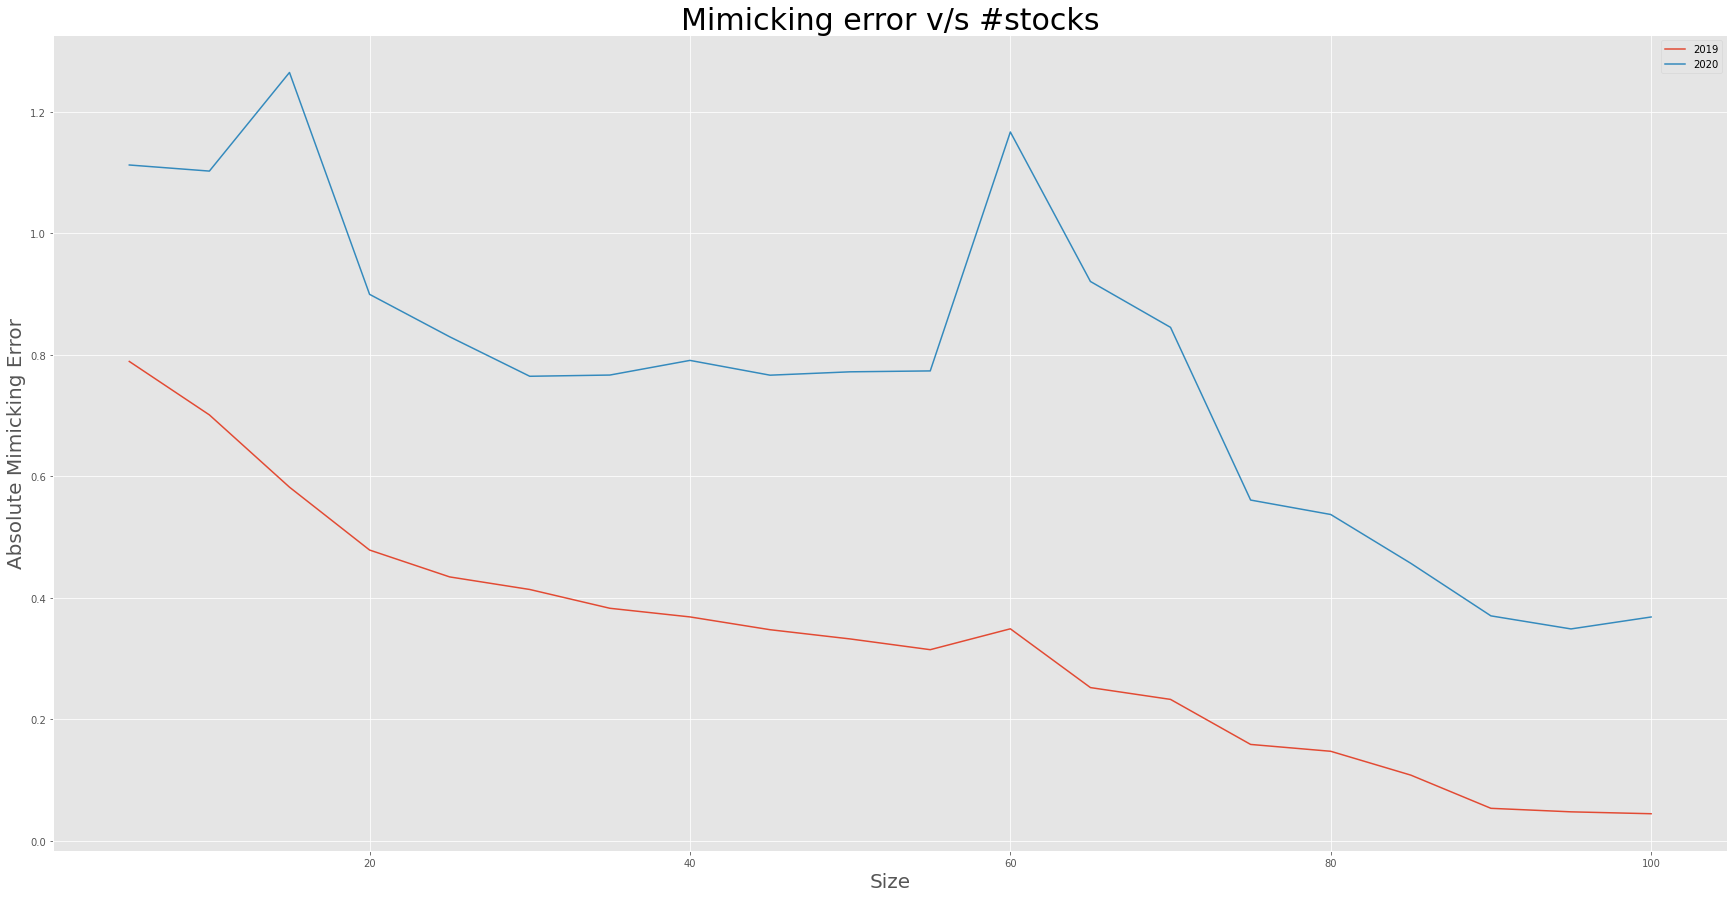

In [37]:
def func2(benchmark: str, data: pd.DataFrame, M: int)-> None:
    tics = stock_selector(M= M)
    idx_ret = data[benchmark].pct_change()[1:]
    stock_ret = data[tics].pct_change()[1:]
    
    wt, error = weight_optimizer(index_returns = idx_ret, returns_data= stock_ret, tickers= tics)
    
    return wt, error

err_19 = pd.Series([], dtype= float)
err_20 = pd.Series([], dtype= float)
for m in tqdm(range(5,len(tic_2019)+1,5)):
# for m in range(5,20,3):
    weights, error = func2("NDX", data= stock_2019, M = m)
    err_19[m] = error
    err_20[m] = abs(index_ret_20 - (weights @ ret_2020[weights.index].T)).sum()

plt.figure(figsize=(30,15))
plt.xlabel("Size", fontsize = 20)
plt.ylabel("Absolute Mimicking Error", fontsize = 20)
plt.title("Mimicking error v/s #stocks", fontsize = 30)
plt.plot(err_19, label = "2019")
plt.plot(err_20, label = "2020")
plt.legend()

In [38]:
p = [x for x in range(10,100, 10)]
print("m=",p)
print("2019 error:",err_19[p],"\n2020 error:", err_20[p])

m= [10, 20, 30, 40, 50, 60, 70, 80, 90]
2019 error: 10    0.701218
20    0.478836
30    0.413917
40    0.368785
50    0.332540
60    0.349217
70    0.233057
80    0.147683
90    0.053827
dtype: float64 
2020 error: 10    1.102404
20    0.899598
30    0.764759
40    0.790884
50    0.772100
60    1.166752
70    0.845242
80    0.537323
90    0.370506
dtype: float64


# $\text{Question }4:$ 

In [39]:
def func4(benchmark: str, data:pd.Series, M: int, verbose: bool = False)-> pd.Series:
    data = data.pct_change().dropna()
    index_returns = data[benchmark]
    returns_data = data.drop(benchmark, axis= 1)


    days, N = returns_data.shape
    tickers = returns_data.columns#.to_list()
    ## Objective Function Vector
    obj  = np.array([1]*days +[0]*( 2*N))
    # [1]*days -> Minimise profit on each day
    # [0]*N   -> 0 for all weight
    # [0]*N   -> 0 for all binary decision variables
    variables = obj.shape[0]
    constraints = 1+ 2*days + N + 1

    vars = [" x"+str(i+1) for i in range(variables)]

    # ## Constraint Matrix
    A = np.zeros((constraints,variables))
    b= pd.Series([1]*constraints)
    sense = pd.Series(["="]*constraints)
    # A[0,0] = 1
    A[0, -2*N: -N] = 1
    i = 1
    for date, row  in returns_data.iterrows():
        A[(2*i) -1 ,   i-1 ] = 1
        A[(2*i) -1 ,   -2*N: -N ] = row.tolist()
        b.iloc[(2*i) -1] = index_returns[date]
        sense.iloc[(2*i) -1] = ">"
        
        A[(2*i) ,   i-1 ] = 1
        A[(2*i) ,   -2*N: -N ] = (-row).tolist()
        b.iloc[(2*i)] = -index_returns[date]
        sense.iloc[(2*i)] = ">"
        i += 1
    
    for i in range(-N-1,-1):
        A[i, i+1] = 1
        A[i, i-N+1] = -1
        b.iloc[i] = 0
        sense.iloc[i] = ">"

    A[-1,-N:] = 1
    b.iloc[-1] = M 

    ## Optimisation Model at work (Maximise)
    model = gb.Model()
    model_X = model.addMVar(variables, vtype= ["C"]*(N+days)+["I"]*N)
    model_constraints = model.addMConstrs(A, model_X, sense, b)
    model.setMObjective(None, obj, 0, sense=gb.GRB.MINIMIZE)
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = GUROBI_TIMER

    model.optimize()
    optimal_obj = model.objVal
    optimal_values = model_X.x[days:].reshape((2,N))

    tickers = tickers[optimal_values[1] != 0]
    optimal_values = optimal_values[0][optimal_values[1] != 0]
    
    # Output 
    if verbose:
        if days <= 3:
            print_equations(obj, A, sense, b)
        print("Optimal Cost to the nearest dollar:", round(optimal_obj,5))
        print("Optimal Weights to select:", optimal_values)
    return pd.Series(optimal_values, index = tickers), optimal_obj

100%|██████████| 10/10 [7:00:47<00:00, 2524.71s/it]


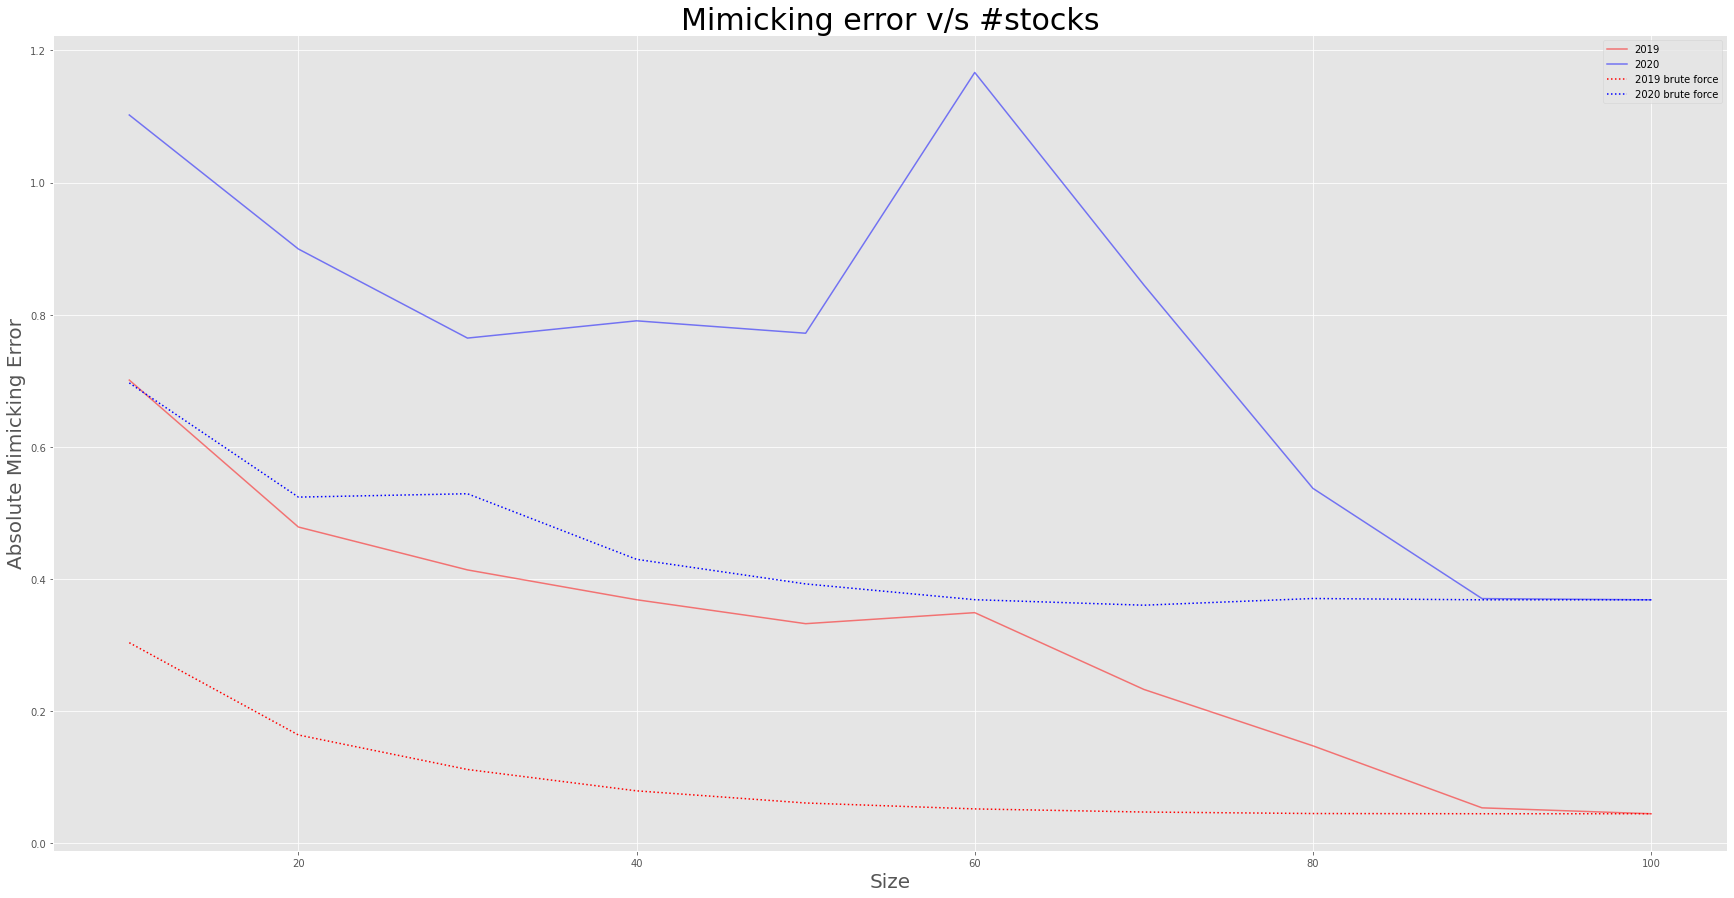

In [40]:
err_19 = pd.Series([], dtype= float)
err_20 = pd.Series([], dtype= float)

err_19_brute = pd.Series([], dtype= float)
err_20_brute = pd.Series([], dtype= float)
for m in tqdm(range(10,len(tic_2019)+1,10)):
# for m in tqdm(range(5,20,3)):
    weights, error = func2("NDX", data= stock_2019, M = m)
    err_19[m] = error
    err_20[m] = abs(index_ret_20 - (weights @ ret_2020[weights.index].T)).sum()
    
    weights_brute, error_brute = func4("NDX", data= stock_2019, M = m)
    err_19_brute[m] = error_brute
    err_20_brute[m] = abs(index_ret_20 - (weights_brute @ ret_2020[weights_brute.index].T)).sum()

plt.figure(figsize=(30,15))
plt.xlabel("Size", fontsize = 20)
plt.ylabel("Absolute Mimicking Error", fontsize = 20)
plt.title("Mimicking error v/s #stocks", fontsize = 30)
plt.plot(err_19, label = "2019", color = "red", alpha = 0.5)
plt.plot(err_20, label = "2020", color = "blue", alpha = 0.5)

plt.plot(err_19_brute, label = "2019 brute force", linestyle = "dotted", color = "red")
plt.plot(err_20_brute, label = "2020 brute force", linestyle = "dotted", color = "blue")
plt.legend()
plt.savefig("mimicking_error.jpg")

In [41]:
df = pd.DataFrame()
df["2019 Error"] = err_19
df["2020 Error"] = err_20
df["2019 Error (Brute Force)"] = err_19_brute
df["2020 Error (Brute Force)"] = err_20_brute
df.to_csv("mimicking_error.csv")
df.tail()

,2019 Error,2020 Error,2019 Error (Brute Force),2020 Error (Brute Force)
60,0.349217,1.166752,0.052220,0.368844
70,0.233057,0.845242,0.047488,0.360502
80,0.147683,0.537323,0.045227,0.370629
90,0.053827,0.370506,0.044911,0.368671
100,0.044911,0.368671,0.044911,0.368682


***
# END
***